# Ruby spectrum

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from modules import utils
import pandas as pd
import ast
import scipy as sp
from matplotlib import cm
from functools import partial
from typing import Literal

OUT_PATHS = {
    'figs_dir' : './figures',
    'results_dir' : './results',
}
IN_PATHS = {
    'black_body_dir' : './raw_data/Black_Body_Radiation',
    'na_dir' : './raw_data/Na_Spectrum',
    'ruby_dir' : './raw_data/Ruby_Spectrum',
    'laser_dir' : './raw_data/Laser_Spectrum',
}

# default figure settings
FIG_SIZE = np.array([6.4, 4]) # 16:10 aspect ratio
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

# setting up stuff
savefig = partial(utils.save_fig, fig_dir=OUT_PATHS['figs_dir'], fig_fmt=FIG_FMT, fig_size=FIG_SIZE, save=SAVE_FIG, transparent_png=TRANSPARENT_PNG)
utils.check_paths(IN_PATHS, OUT_PATHS)

plt.close('all')

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
0,Rb,001,07112024,300ms,450V,2tac,2tac,307Hz,NaN,690.106018,700.0,0.100830,99
1,Rb,002,07112024,300ms,450V,1tac,1tac,307Hz,NaN,688.060242,700.0,0.060242,199
2,Rb,003,07112024,300ms,450V,1tac,1tac,307Hz,NaN,700.210510,730.0,0.150452,199
3,Rb,004,07112024,300ms,450V,1tac,1tac,307Hz,NaN,730.304565,750.0,0.124756,159
4,Rb,005,07112024,300ms,450V,1tac,1tac,307Hz,NaN,689.074158,705.0,0.064331,249
5,Rb,001,14112024,300ms,700V,2tac,2tac,307Hz,300K,689.064331,705.0,0.064087,249
6,Rb,002,14112024,300ms,700V,2tac,2tac,307Hz,77K,689.041687,701.5,0.041931,299
7,Rb,003,14112024,300ms,700V,2tac,2tac,307Hz,77K,700.060242,718.0,0.060059,299
8,Rb,004,14112024,300ms,700V,2tac,2tac,307Hz,4p7-5mV,689.071655,701.5,0.041748,299
9,Rb,005,14112024,300ms,700V,2tac,2tac,307Hz,5mV,695.149841,710.0,0.049866,299


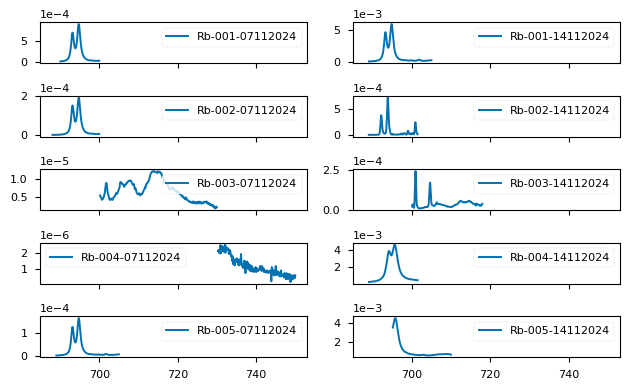

In [14]:
files = utils.getFiles('Raw_Data\\Ruby_Spectrum')
files = [file for file in files if file.name.find('Rb_') != -1]
df = pd.DataFrame([utils.file_to_series(file) for file in files])

# to nano meters
df['wl'] = df['wl'].apply(lambda x: x / 10)

# sort it
df.sort_values('id', inplace=True)
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):       
    # A quick look at the batch
    fig, axs = plt.subplots(5, 2, sharex=True, figsize = FIG_SIZE * 2.5, layout='tight')
    for i, row in df.iterrows():
        meta = ast.literal_eval(row['meta'])
        label = "-".join([meta.get(key) for key in ['type', 'id', 'date',]])
        axs[ i % 5, int(i / 5)].plot(row['wl'], row['mean'], label=label)
        
    for ax in axs.flat:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
        ax.legend()
        
    savefig(fig, 'ruby_batch')
    
# generate the info table
info = df['meta'].apply(ast.literal_eval).apply(pd.Series)
info = info[['type', 'id', 'date'] + [col for col in info.columns if col not in ['type', 'id', 'date']]]
info['start'] = df['wl'].apply(lambda x: x[0])
info['stop'] = df['wl'].apply(lambda x: x[-1])
info['step'] = df['wl'].apply(lambda x: x[1] - x[0])
info['samples'] = df['wl'].apply(len)

info

In [15]:
from scipy.interpolate import interp1d

def mean_overlap(comm_wl : np.ndarray, batch : pd.DataFrame):
    ''' 
    This function computes the mean of varius slices of
    batch over an interval
    '''
    
    # this is the result
    mean = np.zeros(len(comm_wl))
    
    # this counts the number of samples 
    # in each wl
    counts = np.zeros(len(comm_wl))
    
    for i, row in batch.iterrows():
        wl = row['int_wl']
        y = row['int_mean']
        min = np.argmax(comm_wl >= wl.min())
        max = np.argmax(comm_wl > wl.max())
        
        # if the max is 0, it means that the wl is larger than the maximum
        if max == 0:
            max = len(comm_wl)

        mean[min:max]  =  mean[min:max] + y
        counts[min:max] = counts[min:max] + 1
    
    mean = np.divide(mean, counts, out=np.zeros_like(mean), where=counts!=0)
    return mean

def myinterp(series, x_new):
    # extract the x and y values
    x = series['wl']
    y = series['mean']
    
    # keep only the values that are within the range
    mask = np.logical_and(x_new > x.min(), x_new < x.max())
    x_new = x_new[mask]
    
    # return both the new x and the interpolated values
    f = interp1d(x, y, kind='linear')
    return x_new, f(x_new)

def interpolate_batch(batch, common_wl):
    ''' 
    If normalization is not given divide by the maximum value
    '''    
    # interpolate the batch
    batch['interp'] = batch.apply(myinterp, x_new = common_wl, axis=1).to_numpy()
    batch['int_wl'] = batch['interp'].apply(lambda x: x[0])
    batch['int_mean'] = batch['interp'].apply(lambda x: x[1])

    common_mean = mean_overlap(common_wl, batch)
    return common_mean

def plot_interp_batch(batch, common_wl, common_mean):
    fig, axs = plt.subplots(2, 1, figsize=(7, 7))
    # inset 
    inset = axs[0].inset_axes([0.4, 0.5, 0.5, 0.6])
    inset.set_xlim(698, 703)
    inset.set_ylim(0, .07)
    inset.set(yticks=[])
    
    # plot the mean
    axs[0].plot(common_wl, common_mean, label='mean', alpha = 0.7, zorder = 2)
    inset.plot(common_wl, common_mean, label='mean', alpha = 0.5, zorder = 2)

    # plot the interpolated batch
    batch['interp'].apply(lambda x: axs[0].plot(x[0], x[1], alpha=0.2, zorder = 1))
    batch['interp'].apply(lambda x: inset.plot(x[0], x[1], alpha=0.3, zorder = 1))

    # plot a clean result in log scale
    axs[1].plot(common_wl, common_mean, label='mean', alpha = 0.7, zorder = 2)
    axs[1].set_yscale('log')

    for ax in axs.flat:
        ax.legend()  
    return axs

def normalize(series : pd.Series , ids : list, norm = None):
    if not (series['id'] in ids):
        return series
    
    if norm is None:
        norm = series['mean'].max()
   
    series['mean'] = series['mean'] / norm
    return series

# @ room temperature
mask = df['date'] == '07112024' 
batch_0 = df[mask]
display(info[mask])
  
batch_0 = batch_0.apply(normalize, ids = ['001', '002', '005'] ,  axis=1)
batch_0 = batch_0.apply(normalize, ids = ['003', '004'] ,  axis=1, norm = 0.000179)

common_wl = np.arange(680, 750, 0.1)
common_mean = interpolate_batch(batch_0, common_wl)

axs = plot_interp_batch(batch_0, common_wl, common_mean)

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
0,Rb,001,07112024,300ms,450V,2tac,2tac,307Hz,NaN,690.106018,700.0,0.100830,99
1,Rb,002,07112024,300ms,450V,1tac,1tac,307Hz,NaN,688.060242,700.0,0.060242,199
2,Rb,003,07112024,300ms,450V,1tac,1tac,307Hz,NaN,700.210510,730.0,0.150452,199
3,Rb,004,07112024,300ms,450V,1tac,1tac,307Hz,NaN,730.304565,750.0,0.124756,159
4,Rb,005,07112024,300ms,450V,1tac,1tac,307Hz,NaN,689.074158,705.0,0.064331,249


,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
5,Rb,001,14112024,300ms,700V,2tac,2tac,307Hz,300K,689.064331,705.0,0.064087,249
6,Rb,002,14112024,300ms,700V,2tac,2tac,307Hz,77K,689.041687,701.5,0.041931,299
7,Rb,003,14112024,300ms,700V,2tac,2tac,307Hz,77K,700.060242,718.0,0.060059,299
8,Rb,004,14112024,300ms,700V,2tac,2tac,307Hz,4p7-5mV,689.071655,701.5,0.041748,299
9,Rb,005,14112024,300ms,700V,2tac,2tac,307Hz,5mV,695.149841,710.0,0.049866,299


C:\Users\alber\AppData\Local\Temp\ipykernel_21828\3991771773.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_0['temp'] = info.loc[mask, 'temp'].values
C:\Users\alber\AppData\Local\Temp\ipykernel_21828\3991771773.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_0['temp_groups'] = ['300K', '77K', '77K', '400K', '400K']
C:\Users\alber\AppData\Local\Temp\ipykernel_21828\3991771773.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

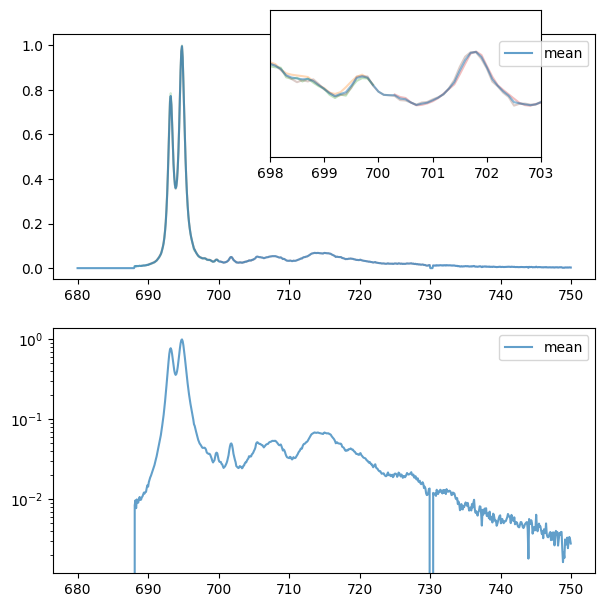

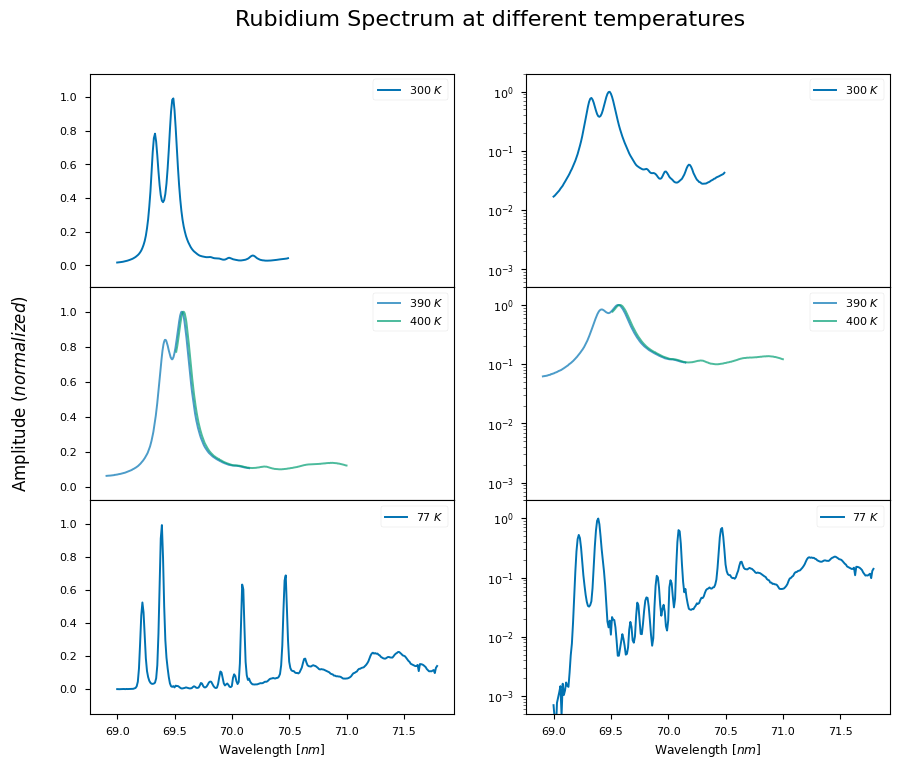

In [16]:
mask = df['date'] == '14112024' 
batch_0 = df[mask]
display(info[mask])

# add the temperature
batch_0['temp'] = info.loc[mask, 'temp'].values

# HACk
batch_0['temp_groups'] = ['300K', '77K', '77K', '400K', '400K']
batch_0['temp'] = ['300K', '77K', '77K', '390K', '400K']
ids = ['001', '002', '003', '004', '005']

common_wl = np.arange(690, 720, 0.1)
with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):       
    fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharex=True)
    i = 0
    for gid, group in batch_0.groupby('temp_groups'):

        # normalize the group
        group = group.apply(normalize, axis=1, ids = ids)

        # interpolate the group    
        if gid == '400K':
            group.apply(lambda x: axs[i, 0].plot(x['wl'] / 10, x['mean'], alpha=0.7, 
                                                label = r'${}\ K$'.format(x['temp'][:-1])), axis=1)
            group.apply(lambda x: axs[i, 1].plot(x['wl'] / 10, x['mean'], alpha=0.7, 
                                                label = r'${}\ K$'.format(x['temp'][:-1])), axis=1)
        else:
            label = r'${}\ K$'.format(gid[:-1])
            common_mean = interpolate_batch(group, common_wl)
            # plot
            mask = common_mean > 0
            axs[i, 0].plot(common_wl[mask] / 10, common_mean[mask], label=label)
            axs[i, 1].plot(common_wl[mask] / 10, common_mean[mask], label=label)
            
        axs[i, 0].margins(y=0.15)
        axs[i, 1].set_ylim(5e-4, 2)
        axs[i, 1].set_yticks([1e-3, 1e-2, 1e-1, 1])
        axs[i, 1].margins(y=0.15)
        axs[i, 1].set_yscale('log')
        i = i + 1

    fig.subplots_adjust(hspace=0, left=0.1, right=0.9, top=0.9, bottom=0.1)
    fig.supylabel('Amplitude $(normalized)$')
    fig.suptitle('Rubidium Spectrum at different temperatures', fontsize=16)

    # common_mean = interpolate_batch(batch_0, common_wl)
    for ax in axs.flat:
        ax.set_xlabel('Wavelength $[nm]$')
        ax.legend()
    plt.show()

# Lifetime of the excited state

In [17]:
from modules import utils
import pandas as pd
import numpy as np
files = utils.getFiles('Raw_Data\\Ruby_Spectrum')
files = [file for file in files if file.name.find('RbTR_') != -1]

def TRtoSeries(file):
    data = np.loadtxt(file, skiprows=9, delimiter=',', usecols=(0, 1, 2)).T
    
     # get the meta data
    tokens = file.name.removesuffix('.csv')
    tokens = tokens[:-14]
    meta = utils.token_parser(tokens)
    
    ser = pd.Series()
    ser['type'] = meta['type']
    ser['date'] = meta['date']
    ser['id'] = file.name[5:8]
    ser['t'] = data[0]
    ser['A'] = data[1]
    ser['B'] = data[2]
    ser['meta'] = str(meta)
    return ser

df = pd.DataFrame([TRtoSeries(file) for file in files])
df


,type,date,id,t,A,B,meta
0,RbTR,20241114,001,"[-0.02644408, -0.026392144, -0.026340208, -0.0...","[-0.6781006, -0.6804239, -0.683693, -0.6784613...","[-0.01372712, -0.01374009, -0.01369153, -0.013...","{'type': 'RbTR', 'id': '141124', 'lock freq': ..."
1,RbTR,20241114,001,"[-0.03740544, -0.037332096, -0.037258752, -0.0...","[-0.4444508, -0.4502739, -0.4519141, -0.450252...","[4.973493, 4.973597, 4.973486, 4.973451, 4.973...","{'type': 'RbTR', 'id': '001', 'lock freq': '54..."
2,RbTR,20241114,002,"[-0.03740544, -0.037332096, -0.037258752, -0.0...","[-0.4444508, -0.4502739, -0.4519141, -0.450252...","[4.973493, 4.973597, 4.973486, 4.973451, 4.973...","{'type': 'RbTR', 'id': '002', 'lock freq': '47..."
3,RbTR,20241114,003,"[-0.031408192, -0.031339264, -0.031270336, -0....","[-0.1929518, -0.202507, -0.2133351, -0.2206596...","[4.973063, 4.973041, 4.973, 4.973025, 4.973091...","{'type': 'RbTR', 'id': '003', 'lock freq': '59..."
4,RbTR,20241114,004,"[-0.031408192, -0.031339264, -0.031270336, -0....","[-0.2231806, -0.2132816, -0.2148061, -0.222415...","[-0.01382952, -0.01383071, -0.01381572, -0.013...","{'type': 'RbTR', 'id': '004', 'lock freq': '67..."
5,RbTR,20241114,005,"[-0.031408192, -0.031339264, -0.031270336, -0....","[-0.6727112, -0.6782766, -0.6750419, -0.679298...","[-0.0131992, -0.0132642, -0.01330316, -0.01328...","{'type': 'RbTR', 'id': '005', 'lock freq': '47..."
6,RbTR,20241114,006,"[-0.041475456, -0.041386752, -0.041298048, -0....","[-0.162637, -0.1615292, -0.1684191, -0.1690794...","[4.95736, 4.957396, 4.957384, 4.957496, 4.9574...","{'type': 'RbTR', 'id': '6939A', 'lock freq': '..."
7,RbTR,20241114,007,"[-0.041475456, -0.041386752, -0.041298048, -0....","[-0.05583937, -0.06066707, -0.05556345, -0.053...","[4.956958, 4.956864, 4.956827, 4.956871, 4.956...","{'type': 'RbTR', 'id': '6939A', 'lock freq': '..."
8,RbTR,20241114,008,"[-0.041475456, -0.041386752, -0.041298048, -0....","[-0.119908, -0.1225011, -0.1210703, -0.1185373...","[-0.0310686, -0.03104122, -0.03104541, -0.0311...","{'type': 'RbTR', 'id': '6939A', 'lock freq': '..."
9,RbTR,20241114,009,"[-0.041475456, -0.041386752, -0.041298048, -0....","[-0.1783948, -0.1717931, -0.1768615, -0.166796...","[-0.03397169, -0.03412743, -0.03418391, -0.034...","{'type': 'RbTR', 'id': '6939A', 'lock freq': '..."


In [18]:
with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):       
    fig, axs = plt.subplots(figsize=FIG_SIZE)
    df.apply(lambda x: plt.plot(x['t'], x['A']), axis = 1)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
def expFlipFlop(t, tau, T):
    ''' 
    t: time in [s]
    tnot: starting time [s]
    tau: lifetime [s]
    T: window of periodicity [s]
    
    note: T should be the FULL period of the 
    square wave with 50% duty cycle
    '''
    
    Thalf = T / 2
    
    tstar = np.mod(t, Thalf)
    tprime = tau * np.log(1+np.exp(-Thalf / tau))
    
    widownum = np.floor_divide(t, Thalf)
    risingedg = np.remainder(widownum + 1, 2)
    fallingedg = np.remainder(widownum, 2)
    
    A = 1 - np.exp(-(Thalf + tprime)/ tau)
    
    rising = 1 - np.exp(- (tstar + tprime) * risingedg / tau)
    falling = A * np.exp(- tstar * fallingedg / tau)
              
    return rising * risingedg + falling * fallingedg

t = np.linspace(0,10,100)
A = expFlipFlop(t - 0.4, 1.9, 0.1)
plt.plot(t, A)

In [20]:
from lmfit.models import Model
batch = df.iloc[0]
display(batch)

# START FROM T=0
t = batch['t'] - batch['t'][0]

# negative tension
A = - batch['A']

def expFlipFlop2(t, tau, tnot, T, A):
    return A * expFlipFlop(t - tnot, tau, T)

model = Model(expFlipFlop2)
params = model.make_params()

params['A'].set(0.7, min = 0)
params['tau'].set(0.007, min = 0)
params['T'].set(0.02, min = 0)
params['tnot'].set(0.01)

result = model.fit(A, params, t=t)
print(result.fit_report())

plt.plot(t, A)
plt.plot(t, model.eval(params, t=t))
plt.plot(t, result.best_fit)

type                                                 RbTR
date                                             20241114
id                                                    001
t       [-0.02644408, -0.026392144, -0.026340208, -0.0...
A       [-0.6781006, -0.6804239, -0.683693, -0.6784613...
B       [-0.01372712, -0.01374009, -0.01369153, -0.013...
meta    {'type': 'RbTR', 'id': '141124', 'lock freq': ...
Name: 0, dtype: object

[[Model]]
    Model(expFlipFlop2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 1024
    # variables        = 4
    chi-square         = 0.05009239
    reduced chi-square = 4.9110e-05
    Akaike info crit   = -10155.5667
    Bayesian info crit = -10135.8408
    R-squared          = 0.99866637
[[Variables]]
    tau:   0.00431185 +/- 7.3805e-06 (0.17%) (init = 0.007)
    tnot:  0.00976284 +/- 4.4437e-06 (0.05%) (init = 0.01)
    T:     0.01853714 +/- 3.4136e-06 (0.02%) (init = 0.02)
    A:     0.75973751 +/- 4.4714e-04 (0.06%) (init = 0.7)
[[Correlations]] (unreported correlations are < 0.100)
    C(tnot, T)   = -0.6597
    C(tau, tnot) = -0.4725
    C(tau, A)    = +0.4074
    C(tnot, A)   = -0.3090
    C(T, A)      = +0.2165
    C(tau, T)    = +0.1193


In [ ]:
import lmfit

expFlipFlop_model = Model(expFlipFlop2)

def fliflop_dataset(params, i, t):
    """Calculate Gaussian lineshape from parameters for data set."""
    t = t[i]
    A = params[f'A_{i+1}']
    tau = params[f'tau_{i+1}']
    T = params[f'T_{i+1}']
    tnot = params[f'tnot_{i+1}']
    return expFlipFlop2(t, tau, tnot, T, A)


# Objective function to fit multiple datasets
def objective(params, t, data):
    """Compute total residuals for all datasets."""
    ndata = len(data)  # Number of datasets
    resid = []

    for i in range(ndata):
        model_values = fliflop_dataset(params, i, t[i])  # Compute model
        resid.append(data[i] - model_values)  # Compute residuals

    return np.concatenate(resid)  # Flatten into 1D array

t = df['t'].to_numpy()
amp = (-1 * df['t']).to_numpy()

fit_params = lmfit.Parameters()
for iy, y in enumerate(amp):
    fit_params.add(f'A_{iy+1}', value = 0.7, min = 0)
    fit_params.add(f'tau_{iy+1}', value = 0.007, min = 0)
    fit_params.add(f'T_{iy+1}', value = 0.02, min = 0)
    fit_params.add(f'tnot_{iy+1}', value = 0)

# ---- Fit the Model ----
result = lmfit.minimize(objective, fit_params, args=(t, amp))

# ---- Print Results ----
print(lmfit.fit_report(result))

[array([-0.02644408, -0.02639214, -0.02634021, ...,  0.02658258,
         0.02663451,  0.02668645])
 array([-0.03740544, -0.0373321 , -0.03725875, ...,  0.03747878,
         0.03755213,  0.03762547])
 array([-0.03740544, -0.0373321 , -0.03725875, ...,  0.03747878,
         0.03755213,  0.03762547])
 array([-0.03140819, -0.03133926, -0.03127034, ...,  0.0389673 ,
         0.03903622,  0.03910515])
 array([-0.03140819, -0.03133926, -0.03127034, ...,  0.0389673 ,
         0.03903622,  0.03910515])
 array([-0.03140819, -0.03133926, -0.03127034, ...,  0.0389673 ,
         0.03903622,  0.03910515])
 array([-0.04147546, -0.04138675, -0.04129805, ...,  0.04909133,
         0.04918003,  0.04926874])
 array([-0.04147546, -0.04138675, -0.04129805, ...,  0.04909133,
         0.04918003,  0.04926874])
 array([-0.04147546, -0.04138675, -0.04129805, ...,  0.04909133,
         0.04918003,  0.04926874])
 array([-0.04147546, -0.04138675, -0.04129805, ...,  0.04909133,
         0.04918003,  0.04926874])


In [67]:
# ---- Plot the Results ----
fig, axes = plt.subplots(8, 5, figsize=(15, 20))  # 8 rows, 5 columns for 40 datasets
axes = axes.flatten()  # Convert to a 1D array for easy iteration

for i in range(39):
    ax = axes[i]
    
    # Plot original data (scatter)
    ax.scatter(t[i], amp[i], color='blue', s=5, label="Data")
    
    # Plot fitted curve (smooth line)
    fitted_curve = fliflop_dataset(result.params, i, t[i])
    ax.plot(t[i], fitted_curve, color='red', linewidth=1.5, label="Fit")

    # Labels & Title
    ax.set_title(f"Dataset {i+1}", fontsize=10)
    ax.set_xlabel("Time (t)")
    ax.set_ylabel("Amplitude")
    ax.legend(fontsize=8)

# Adjust layout
plt.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1024,) and (1,)